# Data-driven solution of Schrodinger equation

 Not Final But Complete Version (continuous time inference)

In [1]:
"""
@author: Yao Huang
"""

'\n@author: Yao Huang\n'

In [65]:
import torch 
import torch.nn as nn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyDOE import lhs
import argparse
import scipy.io

In [66]:
class SchdgerNet(nn.Module):
    def __init__(self):
        super(SchdgerNet,self).__init__()
        self.lay = 100
        self.net = nn.Sequential(
            nn.Linear(2,self.lay),
            nn.Tanh(),
            nn.Linear(self.lay,self.lay),
            nn.Tanh(),
            nn.Linear(self.lay,self.lay),
            nn.Tanh(),
            nn.Linear(self.lay,self.lay),
            nn.Tanh(),
            nn.Linear(self.lay,2)
        )

    def forward(self, x, t):
        x = torch.cat((x,t),1)
        x = self.net(x)
        return x

    # loss function
    def MSE(self,ypred,ytrue):
        return torch.mean((ypred - ytrue)**2) 

    # Glorot initialization of weight matrix
    def glorot_init_mat(self,shape):
        din = shape[0]
        dout = shape[1]
        var = torch.tensor([2.0/(din+dout)])
        std = torch.sqrt(var)
        mean = torch.tensor([0.0])
        dist = torch.distributions.normal.Normal(mean, std)
        return dist.sample(shape)
    
    def UV_bc(self, xu, xl, t): 
        x_u = xu.clone()
        x_u.requires_grad = True
        x_l = xl.clone()
        x_l.requires_grad = True
        tc = t.clone()
        UVu = self.forward(x_u,tc)
        UVux = torch.autograd.grad(UVu.sum(),x_u,create_graph=True)[0]
        UVl = self.forward(x_l,tc)
        UVlx = torch.autograd.grad(UVl.sum(),x_l,create_graph=True)[0]
        return UVu, UVl, UVux, UVlx
    
    def UV_g(self, x, t):
        x_f = x.clone()
        x_f.requires_grad = True
        t_f = t.clone()
        t_f.requires_grad = True
        UV = self.forward(x_f,t_f)
        U = UV[:,0:1]
        V = UV[:,1:2]
        Ut = torch.autograd.grad(U.sum(),t_f,create_graph=True)[0]
        Ux = torch.autograd.grad(U.sum(),x_f,create_graph=True)[0]
        Uxx = torch.autograd.grad(Ux.sum(),x_f,create_graph=True)[0]
        Vt = torch.autograd.grad(V.sum(),t_f,create_graph=True)[0]
        Vx = torch.autograd.grad(V.sum(),x_f,create_graph=True)[0]
        Vxx = torch.autograd.grad(Vx.sum(),x_f,create_graph=True)[0]
        D = U**2+V**2
        F1 = Ut+0.5*Vxx+ D*V
        F2 = Vt-0.5*Uxx-D*U
        return F1, F2

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyDOE import lhs
import argparse
import scipy.io

In [68]:
parser = argparse.ArgumentParser()
parser.add_argument("--epochs", help="Number of epochs to train neural network for")

"""data prep"""
"""
DE: u_t+0.5*v_{xx}+g*v=0
    v_t-0.5*u_{xx}-g*u=0
g = \sqrt{u^2+v^2}
"""
args = parser.parse_args(['--epochs','50000'])

In [69]:
data = scipy.io.loadmat('Data/NLS.mat')
    
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

In [71]:
N0,N_b,N_f = 50,50,20000
# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
# Generate samples for x, t
#sample points
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

idx_star = 0
t_star = t[idx_star,:]+0*x
#t_star = 0.79+0*x
h_star = Exact_h[:,idx_star]  

X_f = lb + (ub-lb)*lhs(2, N_f)

In [72]:
# %%
# Generate samples for x, t, u [boundary initial conditions]
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)

In [73]:

"""NN class, init, loss functions, dataloader"""

# %%
"""training process"""

# %%
#load u v
Exact_u = torch.tensor(Exact_u).type(torch.FloatTensor)
Exact_v = torch.tensor(Exact_v).type(torch.FloatTensor)
Exact_h = torch.tensor(Exact_h).type(torch.FloatTensor)
#load initial condition data
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
UV0 = torch.cat((u0,v0),1)
# load x, t data into torch
x0 = x0.reshape((-1, 1))
x0 = torch.tensor(x0).type(torch.FloatTensor)
tb = tb.reshape((-1, 1))
tb = torch.tensor(tb).type(torch.FloatTensor)

X0 = torch.tensor(X0).type(torch.FloatTensor)
X_lb = torch.tensor(X_lb).type(torch.FloatTensor)
X_ub = torch.tensor(X_ub).type(torch.FloatTensor)
X_f = torch.tensor(X_f).type(torch.FloatTensor)

In [74]:
# %%
#Instantiate class
pn = SchdgerNet()

#Initialize weights
#Glorot initialization
[W, b] = list(pn.net[0].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[2].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[4].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[6].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

[W, b] = list(pn.net[8].parameters())
W = pn.glorot_init_mat(W.shape)
b.data.fill_(0)

tensor([0., 0.])

In [76]:
# %%
# Perform backprop
MAX_EPOCHS = int(args.epochs)
LRATE = 0.001#3e-4

#Use Adam for training
optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)

loss_history_bc = []
loss_history_ic = []
loss_history_f = []
loss_history = []

In [77]:
import time
start_time = time.time()
for epoch in range(MAX_EPOCHS):
    xc = x0.clone()
    #tc = tb.clone()
    #full batch

    #initial condition
    UV0_pred = pn(xc,0*xc)
    mse_ic = pn.MSE(UV0_pred, UV0)
    loss_history_ic.append([epoch, mse_ic.item()])
    
    
    UVub_pred, UVlb_pred, UVub_pred1, UVlb_pred1 = pn.UV_bc(X_ub[:,0:1],X_lb[:,0:1],tb)
    mse_bc = pn.MSE(UVub_pred, UVlb_pred)+pn.MSE(UVub_pred1, UVlb_pred1)
    loss_history_bc.append([epoch, mse_bc.item()])

    #governing condition
    F1, F2 = pn.UV_g(X_f[:,0:1],X_f[:,1:2])
    mse_f = torch.mean(F1**2)+torch.mean(F2**2) 
    loss_history_f.append([epoch, mse_f.item()])

    loss = mse_ic + mse_bc + mse_f
    loss_history.append([epoch, loss.item()])

    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print("Epoch: {}, MSE_ic: {:.4f}, MSE_bc: {:.4f}, MSE_f: {:.4f}, MSE: {:.4f}".format((epoch+1), mse_ic, mse_bc, mse_f, loss))
elapsed = time.time() - start_time

Epoch: 1000, MSE_ic: 0.0200, MSE_bc: 0.0002, MSE_f: 0.0126, MSE: 0.0329
Epoch: 2000, MSE_ic: 0.0195, MSE_bc: 0.0028, MSE_f: 0.0103, MSE: 0.0326
Epoch: 3000, MSE_ic: 0.0148, MSE_bc: 0.0001, MSE_f: 0.0078, MSE: 0.0227
Epoch: 4000, MSE_ic: 0.0118, MSE_bc: 0.0000, MSE_f: 0.0177, MSE: 0.0295
Epoch: 5000, MSE_ic: 0.0109, MSE_bc: 0.0001, MSE_f: 0.0052, MSE: 0.0161
Epoch: 6000, MSE_ic: 0.0091, MSE_bc: 0.0000, MSE_f: 0.0054, MSE: 0.0146
Epoch: 7000, MSE_ic: 0.0079, MSE_bc: 0.0003, MSE_f: 0.0045, MSE: 0.0127
Epoch: 8000, MSE_ic: 0.0065, MSE_bc: 0.0001, MSE_f: 0.0117, MSE: 0.0183
Epoch: 9000, MSE_ic: 0.0049, MSE_bc: 0.0000, MSE_f: 0.0045, MSE: 0.0094
Epoch: 10000, MSE_ic: 0.0040, MSE_bc: 0.0000, MSE_f: 0.0028, MSE: 0.0069
Epoch: 11000, MSE_ic: 0.0034, MSE_bc: 0.0000, MSE_f: 0.0087, MSE: 0.0121
Epoch: 12000, MSE_ic: 0.0027, MSE_bc: 0.0000, MSE_f: 0.0021, MSE: 0.0048
Epoch: 13000, MSE_ic: 0.0023, MSE_bc: 0.0000, MSE_f: 0.0021, MSE: 0.0044
Epoch: 14000, MSE_ic: 0.0019, MSE_bc: 0.0000, MSE_f: 0.0017,

In [78]:
elapsed

16404.90438103676

In [79]:
#%%
#save trained model
fname = "SchdgerNet_{}.pt".format(N_f)
torch.save(pn, fname)

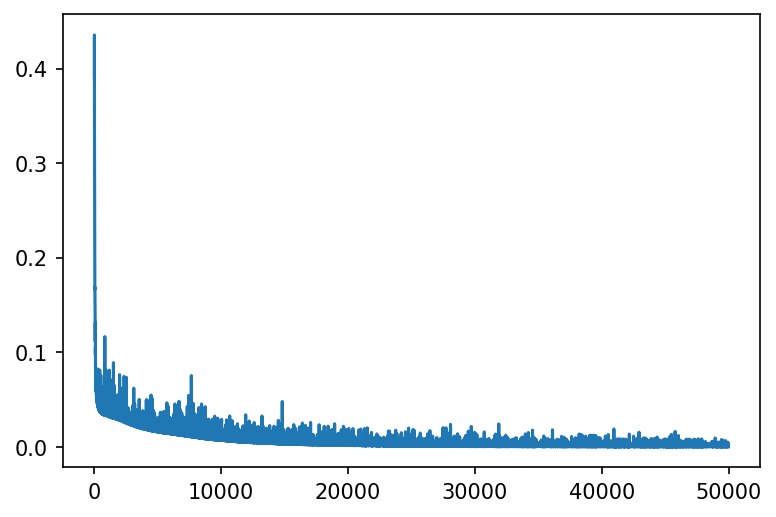

In [80]:
#%%
loss_history = np.array(loss_history)
plt.figure(dpi=150)
plt.plot(loss_history[:,0], loss_history[:,1])
#plt.savefig("SchdgerNet_loss_hist_{}.png".format(N_f))
#plt.show()

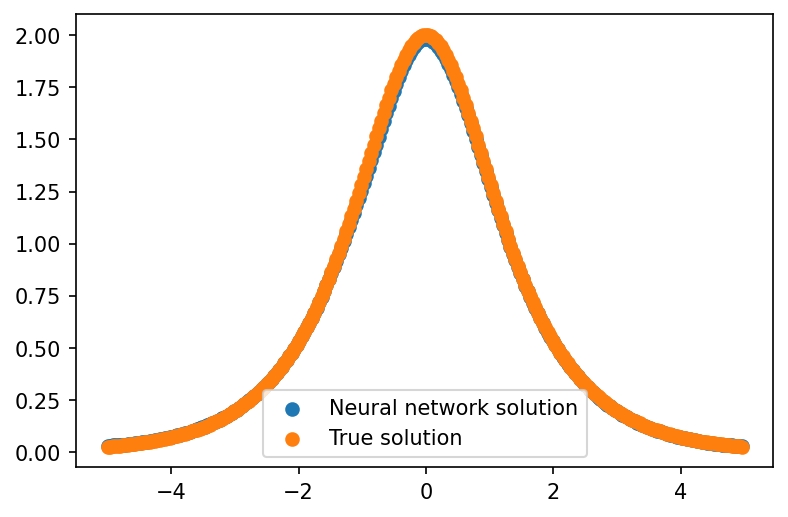

In [81]:
#%%
plt.figure(dpi=150)
x = torch.tensor(x).type(torch.FloatTensor)
t_star = torch.tensor(t_star).type(torch.FloatTensor)
UV_pred = pn(x,t_star)
u_pred = UV_pred[:,0:1]
v_pred = UV_pred[:,1:2]
h_pred = (u_pred**2+v_pred**2).sqrt()
plt.scatter(x.data.numpy(), h_pred.data.numpy(), label="Neural network solution")
plt.scatter(x.data.numpy(), h_star, label="True solution")
plt.legend()
#plt.savefig("PINN_soln_comp_{}.png".format(N_f))
#plt.show()